<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S10%5CS10-T1111.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S10/')

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from config import ModelConfig
from models.resnet import ResNet18
from train import train
from results import plot_images, plot_graph
from utilities import *
from data_engine import DataEngine
from gradcam.visualize import VisualizeCam
from lr_finder import LRFinder
#from test import test

# View model config
args = ModelConfig()
args.print_config()

print()
# Set seed
init_seed(args)

data = DataEngine(args)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


  pip install torch-lr-finder -v --global-option="amp"


Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 128,
  'dropout': 0.15,
  'epochs': 50,
  'l1_decay': 3e-06,
  'l2_decay': 0.001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



plane   dog  deer  deer


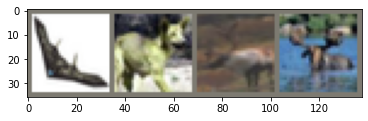

In [4]:
# get some random training images
dataiter = iter(data.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % data.classes[labels[j]] for j in range(4)))





In [5]:
device = which_device()
net = ResNet18(args.dropout)
model = net.to(device)
show_model_summary(model, (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
def test(model, device, test_loader, criterion, classes, test_losses, test_accs,
         misclassified_imgs, correct_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss +=criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 25:
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind]
                })
              
              correct_inds = (is_correct==1).nonzero()[:,0]
              for ind in correct_inds:
                if len(correct_imgs) == 25:
                  break
                correct_imgs.append({
                    "target": target[ind].cpu().numpy(),
                    "pred": pred[ind][0].cpu().numpy(),
                    "img": data[ind]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    test_acc = 100. * correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    if test_acc >= 90.0:
        classwise_acc(model, device, test_loader, classes)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_acc))

def classwise_acc(model, device, test_loader, classes):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    # print class-wise test accuracies
    print()
    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))
    print()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


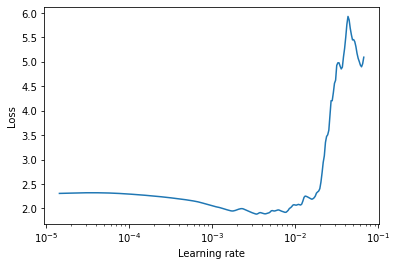

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data.train_loader, val_loader=data.test_loader, start_lr=1e-5, end_lr=2,
                     num_iter=len(data.train_loader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
print('Device set to ', device)

Device set to  cuda


In [9]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))
args.lr = best_lr

Best Loss: 1.881371440490799
Best Learning Rate: 0.003429850696246664


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                              verbose=True, min_lr=1e-5)

def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(args.epochs):
      print("EPOCH:", epoch+1)
      train(model, device, data.train_loader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      test(model, device, data.test_loader, criterion, data.classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==args.epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=459.184814453125 L1_loss=109145.2421875 Loss=1.9101097583770752 Batch_id=390 Accuracy=49.42: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0088, Accuracy: 5939/10000 (59.39%)

EPOCH: 2


L2_loss=459.37164306640625 L1_loss=108865.203125 Loss=1.56440269947052 Batch_id=390 Accuracy=68.31: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0068, Accuracy: 6983/10000 (69.83%)

EPOCH: 3


L2_loss=459.41656494140625 L1_loss=108575.1953125 Loss=1.504319667816162 Batch_id=390 Accuracy=75.29: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0052, Accuracy: 7667/10000 (76.67%)

EPOCH: 4


L2_loss=459.4051818847656 L1_loss=108290.9921875 Loss=1.3389520645141602 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 7879/10000 (78.79%)

EPOCH: 5


L2_loss=459.3518981933594 L1_loss=108013.390625 Loss=1.2198309898376465 Batch_id=390 Accuracy=82.41: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8079/10000 (80.79%)

EPOCH: 6


L2_loss=459.27734375 L1_loss=107742.625 Loss=1.116738200187683 Batch_id=390 Accuracy=84.69: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8218/10000 (82.18%)

EPOCH: 7


L2_loss=459.20855712890625 L1_loss=107484.2265625 Loss=1.120901107788086 Batch_id=390 Accuracy=86.39: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0041, Accuracy: 8247/10000 (82.47%)

EPOCH: 8


L2_loss=459.13482666015625 L1_loss=107235.2421875 Loss=1.1169769763946533 Batch_id=390 Accuracy=87.67: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0044, Accuracy: 8131/10000 (81.31%)

EPOCH: 9


L2_loss=459.0591735839844 L1_loss=106991.25 Loss=1.0486211776733398 Batch_id=390 Accuracy=89.24: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8408/10000 (84.08%)

EPOCH: 10


L2_loss=458.9541015625 L1_loss=106749.7890625 Loss=1.0698398351669312 Batch_id=390 Accuracy=90.34: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0044, Accuracy: 8199/10000 (81.99%)

EPOCH: 11


L2_loss=458.83734130859375 L1_loss=106511.8984375 Loss=0.9780936241149902 Batch_id=390 Accuracy=91.35: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0040, Accuracy: 8346/10000 (83.46%)

EPOCH: 12


L2_loss=458.6986083984375 L1_loss=106274.5 Loss=0.983026921749115 Batch_id=390 Accuracy=92.15: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8276/10000 (82.76%)

EPOCH: 13


L2_loss=458.5399169921875 L1_loss=106044.59375 Loss=1.0664756298065186 Batch_id=390 Accuracy=92.62: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8280/10000 (82.80%)

Epoch    13: reducing learning rate of group 0 to 3.4299e-04.
EPOCH: 14


L2_loss=458.447509765625 L1_loss=105989.015625 Loss=0.9132375717163086 Batch_id=390 Accuracy=95.66: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8806/10000 (88.06%)

EPOCH: 15


L2_loss=458.35931396484375 L1_loss=105933.171875 Loss=0.86629319190979 Batch_id=390 Accuracy=96.60: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8840/10000 (88.40%)

EPOCH: 16


L2_loss=458.2730712890625 L1_loss=105877.359375 Loss=0.8214592933654785 Batch_id=390 Accuracy=97.03: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8836/10000 (88.36%)

EPOCH: 17


L2_loss=458.1885986328125 L1_loss=105821.6171875 Loss=0.8662640452384949 Batch_id=390 Accuracy=97.28: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8833/10000 (88.33%)

EPOCH: 18


L2_loss=458.1061096191406 L1_loss=105766.1015625 Loss=0.9919018745422363 Batch_id=390 Accuracy=97.35: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8837/10000 (88.37%)

EPOCH: 19


L2_loss=458.0267639160156 L1_loss=105710.765625 Loss=0.975350022315979 Batch_id=390 Accuracy=97.58: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8833/10000 (88.33%)

EPOCH: 20


L2_loss=457.9478454589844 L1_loss=105655.3515625 Loss=0.9181942939758301 Batch_id=390 Accuracy=97.80: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8837/10000 (88.37%)

Epoch    20: reducing learning rate of group 0 to 3.4299e-05.
EPOCH: 21


L2_loss=457.9377136230469 L1_loss=105649.46875 Loss=0.8082499504089355 Batch_id=390 Accuracy=97.89: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8844/10000 (88.44%)

EPOCH: 22


L2_loss=457.92840576171875 L1_loss=105643.734375 Loss=0.7984877824783325 Batch_id=390 Accuracy=98.15: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

EPOCH: 23


L2_loss=457.91973876953125 L1_loss=105637.9921875 Loss=0.857429563999176 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8845/10000 (88.45%)

EPOCH: 24


L2_loss=457.9113464355469 L1_loss=105632.2421875 Loss=0.9281889200210571 Batch_id=390 Accuracy=98.11: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

Epoch    24: reducing learning rate of group 0 to 1.0000e-05.
EPOCH: 25


L2_loss=457.90863037109375 L1_loss=105630.5703125 Loss=0.8091484308242798 Batch_id=390 Accuracy=98.17: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8853/10000 (88.53%)

EPOCH: 26


L2_loss=457.9062805175781 L1_loss=105628.8984375 Loss=0.8384146094322205 Batch_id=390 Accuracy=98.01: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8846/10000 (88.46%)

EPOCH: 27


L2_loss=457.9039001464844 L1_loss=105627.2421875 Loss=0.8250380158424377 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8849/10000 (88.49%)

EPOCH: 28


L2_loss=457.9015808105469 L1_loss=105625.5703125 Loss=0.8047670125961304 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8844/10000 (88.44%)

EPOCH: 29


L2_loss=457.89923095703125 L1_loss=105623.8828125 Loss=0.8781810998916626 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8847/10000 (88.47%)

EPOCH: 30


L2_loss=457.8969421386719 L1_loss=105622.21875 Loss=0.8540367484092712 Batch_id=390 Accuracy=98.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

EPOCH: 31


L2_loss=457.89453125 L1_loss=105620.5546875 Loss=0.8611145615577698 Batch_id=390 Accuracy=98.04: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8848/10000 (88.48%)

EPOCH: 32


L2_loss=457.8921813964844 L1_loss=105618.875 Loss=0.8131754398345947 Batch_id=390 Accuracy=98.17: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8850/10000 (88.50%)

EPOCH: 33


L2_loss=457.88983154296875 L1_loss=105617.2109375 Loss=0.8243943452835083 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8846/10000 (88.46%)

EPOCH: 34


L2_loss=457.88751220703125 L1_loss=105615.5390625 Loss=0.8856534957885742 Batch_id=390 Accuracy=98.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8850/10000 (88.50%)

EPOCH: 35


L2_loss=457.88519287109375 L1_loss=105613.8671875 Loss=0.8332592248916626 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8846/10000 (88.46%)

EPOCH: 36


L2_loss=457.8827209472656 L1_loss=105612.1953125 Loss=0.7959533333778381 Batch_id=390 Accuracy=98.13: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

EPOCH: 37


L2_loss=457.8804016113281 L1_loss=105610.53125 Loss=0.8657996654510498 Batch_id=390 Accuracy=98.07: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8844/10000 (88.44%)

EPOCH: 38


L2_loss=457.8780517578125 L1_loss=105608.8515625 Loss=0.8337345123291016 Batch_id=390 Accuracy=98.07: 100%|██████████| 391/391 [03:12<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8847/10000 (88.47%)

EPOCH: 39


L2_loss=457.8757019042969 L1_loss=105607.171875 Loss=0.8020184636116028 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [03:11<00:00,  2.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8847/10000 (88.47%)

EPOCH: 40


L2_loss=457.87322998046875 L1_loss=105605.5234375 Loss=0.8157482147216797 Batch_id=390 Accuracy=98.09: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8849/10000 (88.49%)

EPOCH: 41


L2_loss=457.8710632324219 L1_loss=105603.8359375 Loss=0.8432928919792175 Batch_id=390 Accuracy=98.19: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

EPOCH: 42


L2_loss=457.8685607910156 L1_loss=105602.171875 Loss=0.8197206854820251 Batch_id=390 Accuracy=98.25: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8847/10000 (88.47%)

EPOCH: 43


L2_loss=457.8662414550781 L1_loss=105600.515625 Loss=0.8385293483734131 Batch_id=390 Accuracy=98.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8851/10000 (88.51%)

EPOCH: 44


L2_loss=457.8638610839844 L1_loss=105598.84375 Loss=0.8108533024787903 Batch_id=390 Accuracy=98.29: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8863/10000 (88.63%)

EPOCH: 45


L2_loss=457.861572265625 L1_loss=105597.15625 Loss=0.8218271136283875 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8856/10000 (88.56%)

EPOCH: 46


L2_loss=457.859375 L1_loss=105595.484375 Loss=0.927819013595581 Batch_id=390 Accuracy=98.17: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8845/10000 (88.45%)

EPOCH: 47


L2_loss=457.85693359375 L1_loss=105593.8203125 Loss=0.7932381629943848 Batch_id=390 Accuracy=98.23: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8847/10000 (88.47%)

EPOCH: 48


L2_loss=457.85455322265625 L1_loss=105592.1640625 Loss=0.8435952067375183 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0029, Accuracy: 8850/10000 (88.50%)

EPOCH: 49


L2_loss=457.85223388671875 L1_loss=105590.5 Loss=0.8158336281776428 Batch_id=390 Accuracy=98.13: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8851/10000 (88.51%)

EPOCH: 50


L2_loss=457.8500061035156 L1_loss=105588.828125 Loss=0.8161828517913818 Batch_id=390 Accuracy=98.16: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]


Test set: Average loss: 0.0029, Accuracy: 8857/10000 (88.57%)



Let us show some of the training images, for fun.



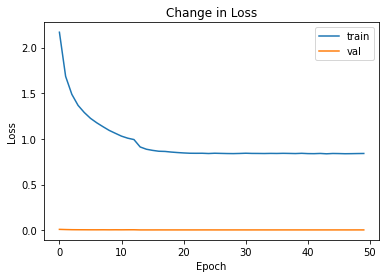

In [11]:
plt_data = {
    "train": train_losses,
    "val": test_losses
}
plot_graph(plt_data, "Loss")

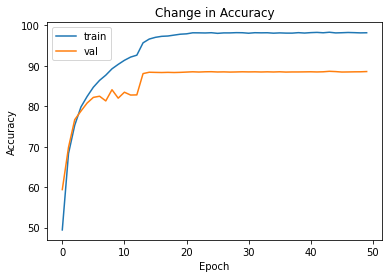

In [12]:

plt_data = {
    "train": train_accs,
    "val": test_accs
}
plot_graph(plt_data, "Accuracy")

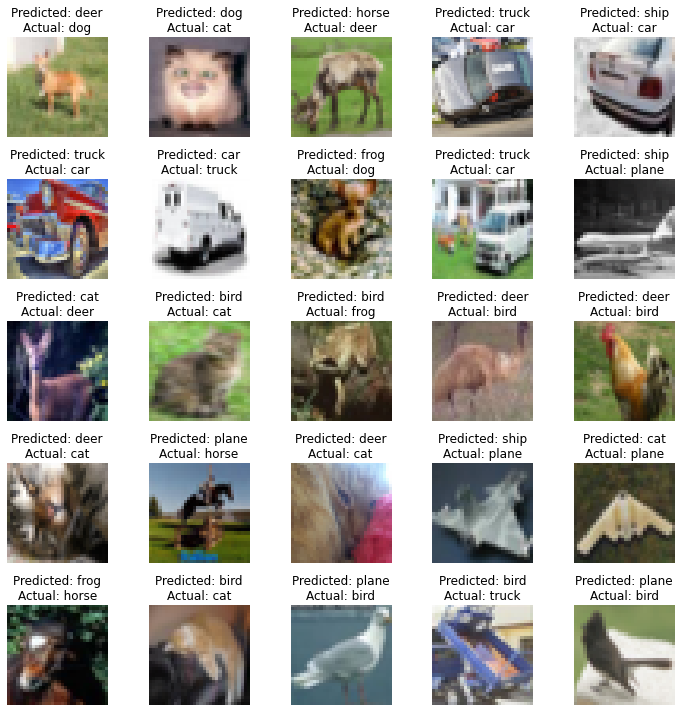

In [13]:
plot_images(misclassified_imgs, data.classes, "misclassified_imgs.png")

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,data.classes, target_layers)

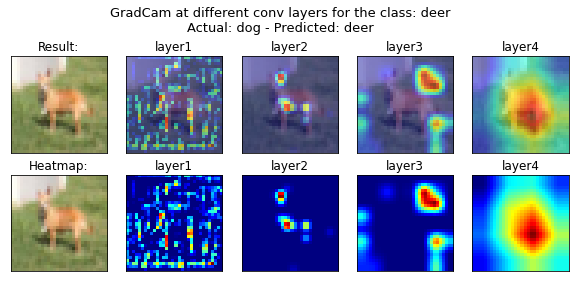

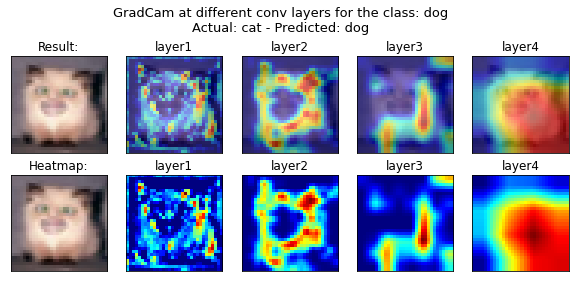

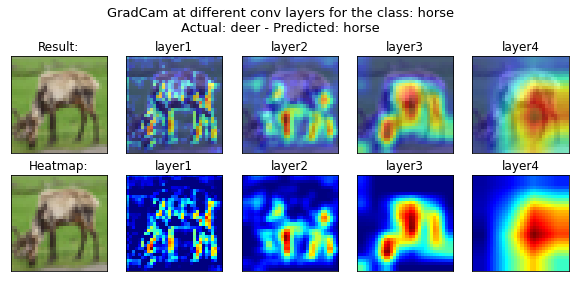

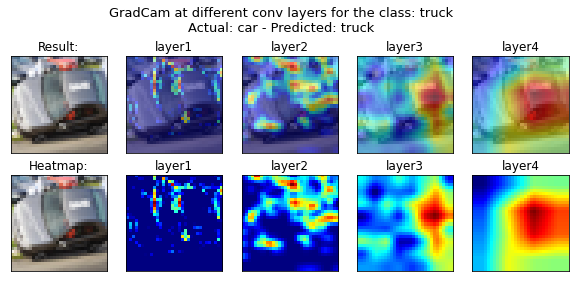

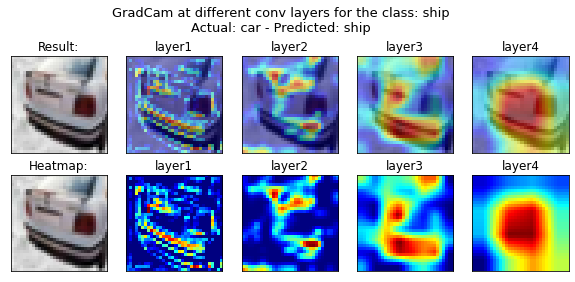

In [15]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

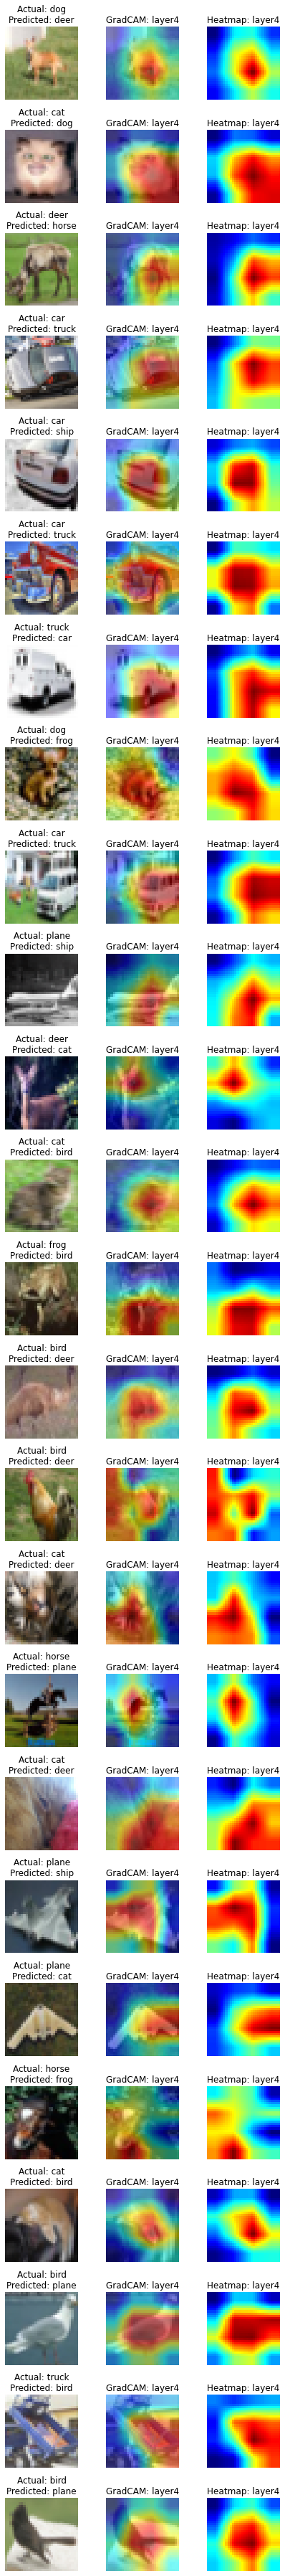

In [16]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)